# Testing notebook

In [2]:
import os 

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')


Project path set to: c:\Github\ode-biomarker-project


## Loading Data

In [2]:
from PathLoader import PathLoader

path_loader = PathLoader('data_config.env', 'current_user.env')

### Load data

import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open(f'{path_loader.get_data_path()}data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)
    
# import CCLE gene expression data using pickle

with open(f'{path_loader.get_data_path()}data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open(f'{path_loader.get_data_path()}data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open(f'{path_loader.get_data_path()}data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open(f'{path_loader.get_data_path()}data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open(f'{path_loader.get_data_path()}data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open(f'{path_loader.get_data_path()}data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)

# open the cache for neighbourhood calculations

with open(f'{path_loader.get_data_path()}data/protein-interaction/STRING/palbociclib_nth_degree_neighbours.pkl', 'rb') as f:
    nth_degree_neighbours = pickle.load(f)

# Toolkit Tests

## Feature Transformer

In [ ]:
import pandas as pd

# loading cell line proteomic expression data

cancercell2022 = pd.read_csv('data\preprocessed\SY-Processed\CancerCell2022_PRISM.csv')

cancercell2022_dropnan = cancercell2022.dropna(subset=['AUC'])

import DataFunctions as dfunc 

feature_data, label_data = dfunc.create_feature_and_label(cancercell2022_dropnan, label_name='AUC')

feature_data_no_row = feature_data.drop(['Row'], axis=1)

In [ ]:
from toolkit import FeatureTransformer
from toolkit import impute_by_zero, impute_by_first_quantile, get_network_stat_features, get_random_features

F = FeatureTransformer()

F.add_transform_function('impute_by_zero', impute_by_zero)
F.add_selection_function('random_select', get_random_features, {"selection_size": 10})

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, random_state=42)

# Print the shapes of the new X objects

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

# Run Feature Transformer 

selected_features, sel_train, sel_test = F.run(X_train, y_train, X_test)

print(selected_features, sel_train.shape, sel_test.shape)  

In [ ]:
# clear variables in juptyer notebook

%reset -f

## Feature Selection Methods

### Create controlled dataset

In [2]:
from sklearn.datasets import make_regression
import pandas as pd

# turn X and Y into dataframes
X, y = make_regression(n_samples=500, n_features=1000, n_informative=10, random_state=1, shuffle=False)

X = pd.DataFrame(X)
y = pd.Series(y)

# turn columns into strings

X.columns = [str(i) for i in range(X.shape[1])]

print(f'Original informative columns: {X.columns[:10]}')

# shuffle columns around for X

X = X.sample(frac=1, axis=1, random_state=0)

print(f'Newly shuffled columns: {X.columns[:10]}')


Original informative columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
Newly shuffled columns: Index(['993', '859', '298', '553', '672', '971', '27', '231', '306', '706'], dtype='object')


In [ ]:
from toolkit import mrmr_select_fcq

features, scores = mrmr_select_fcq(X, y, K=10,verbose=True)

In [ ]:
from toolkit import enet_select

features, scores = enet_select(X, y, 10, max_iter=10000, alpha=0.1, l1_ratio=0.7)

print(features)
print(scores)

In [ ]:
from toolkit import rf_select

features, scores = rf_select(X, y, k=10, n_estimators=100, max_depth=5, n_jobs=-1)

print(features)
print(scores)

In [ ]:
from toolkit import f_regression_select

features, scores = f_regression_select(X, y, k=10)
print(features)
print(scores)

In [ ]:
from toolkit import relieff_select

features, scores = relieff_select(X, y, k=10, n_jobs=4)
print(features)
print(scores)


In [ ]:
# clear variables in juptyer notebook

%reset -f

## Selection Functions

In [ ]:
# import train_test_split function
from sklearn.model_selection import train_test_split
from toolkit import select_random_features

selected_features, selected_X = select_random_features(X, y, 10)

print(selected_features, selected_X.shape)

## Transforming Functions


In [ ]:
from toolkit import transform_impute_by_zero

imputed_X, imputed_y = transform_impute_by_zero(X, y)

print(imputed_X.shape, imputed_y.shape)


In [5]:
# imputation by uniform sampling between 0 and minimum value of each column
import numpy as np 

tampered_X, tampered_y = X.copy(), y.copy()

# randomly replace 10% of the values in X with nan
for row in range(X.shape[0]):
    col = np.random.randint(0, X.shape[1])
    if np.random.rand() < 0.3:
        tampered_X.iloc[row, col] = np.nan
        
print('Original nan count: ', tampered_X.isna().sum().sum())

from toolkit import transform_impute_by_zero_to_min_uniform

imputed_X, imputed_y = transform_impute_by_zero_to_min_uniform(tampered_X, y, assumed_absolute_min=-10)

print('Imputed nan count: ', imputed_X.isna().sum().sum())

Original nan count:  141
Imputed nan count:  0


## Hyperparameter Tuning Functions

In [3]:
from toolkit import hypertune_svr

best_params, best_score, results = hypertune_svr(X, y, cv=5, n_jobs=1)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
print(best_params)
print(best_score)

{'kernel': 'linear'}
0.35143606570346575


In [5]:
df = pd.DataFrame(results)

df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.071533,0.005797,0.012741,0.001749,linear,{'kernel': 'linear'},0.198850,0.381300,0.363661,0.363311,0.450059,0.351436,0.082694,1
1,0.043346,0.001597,0.013444,0.003961,poly,{'kernel': 'poly'},-0.000117,-0.000541,-0.000063,-0.008858,-0.001281,-0.002172,0.003371,4
2,0.052588,0.013861,0.028052,0.004161,rbf,{'kernel': 'rbf'},0.000356,0.000491,0.000724,-0.007306,0.000018,-0.001143,0.003090,3
3,0.045879,0.004190,0.015927,0.002738,sigmoid,{'kernel': 'sigmoid'},0.001534,0.003233,0.002922,-0.003206,0.003311,0.001559,0.002467,2


In [3]:
from toolkit import hypertune_ann
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# best_params, best_score, results = hypertune_ann(X, y, cv=5, n_jobs=1)

# TODO: computational load need to be on VM  

# define the parameter values that should be searched
hidden_layer_sizes_range = [(i, i, i) for i in range(1, 100, 10)]
learning_rate_range = ['constant', 'invscaling', 'adaptive']
param_grid = dict(hidden_layer_sizes=hidden_layer_sizes_range,
                    learning_rate=learning_rate_range)

# instantiate and fit the grid
grid = GridSearchCV(MLPRegressor(max_iter=100000), param_grid, cv=5, scoring='r2', n_jobs=1, verbose=2)
grid.fit(X, y)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.


[CV] END hidden_layer_sizes=(1, 1, 1), learning_rate=constant; total time=  36.0s


Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.


[CV] END hidden_layer_sizes=(1, 1, 1), learning_rate=constant; total time=  35.9s
[CV] END hidden_layer_sizes=(1, 1, 1), learning_rate=constant; total time=   9.2s


## the Powerkit class

In [ ]:
'''Testing code, for reference ONLY
'''

# rng = 45
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)
# get_feature_importance = False
# pipeline_comps = pipeline_func(X_train, y_train)
# eval_returns = eval_func(X_test, y_test, pipeline_components=pipeline_comps)
# # print(eval_returns)

# # combine pipeline_comps and eval_returns into a single dictionary

# final_returns = {}
# final_returns['rng'] = rng
# final_returns['condition'] = 'test'
# final_returns.update(eval_returns)

# if not get_feature_importance:
#     final_returns.pop('feature_importance')

# # convert final_returns into a dataframe, test if it works for multiple rows

# df = pd.DataFrame([final_returns, final_returns])

# df.head()

# feature_importance = final_returns['feature_importance']

# for x,y in zip(feature_importance[0], feature_importance[1]):
#     print(f'Feature: {x}, Score: {y}')

In [1]:
import os 

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

from toolkit import Powerkit, transform_impute_by_zero, select_random_features, select_preset_features, select_stat_features, f_regression_select, mrmr_select_fcq, hypertune_svr, get_variation

from copy import deepcopy

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from scipy.stats import pearsonr

from sklearn.feature_selection import f_regression

# create a Powerkit object

from sklearn.datasets import make_regression
import pandas as pd

# turn X and Y into dataframes
X, y = make_regression(n_samples=500, n_features=1000, n_informative=10, random_state=1, shuffle=False)

X = pd.DataFrame(X)
y = pd.Series(y)

# turn columns into strings

X.columns = [str(i) for i in range(X.shape[1])]

print(f'Original informative columns: {X.columns[:10]}')

# shuffle columns around for X

X = X.sample(frac=1, axis=1, random_state=0)

print(f'Newly shuffled columns: {X.columns[:10]}')


def pipeline_func(X_train, y_train, **kwargs):
    
    X_transformed, y_transformed = transform_impute_by_zero(X_train, y_train)
    # selected_features, scores = f_regression_select(X_transformed, y_transformed, k=10)
    selected_features, scores = mrmr_select_fcq(X_transformed, y_transformed, K=10, return_index=False)
    selected_features, X_selected = select_preset_features(X_transformed, y_transformed, selected_features)
    model = SVR()
    model.fit(X_selected, y_transformed)
    
    return {'model': model, 'selected_features': selected_features, 'scores': scores}

def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    
    '''
    example function to evaluate the performance of a pipeline
    inputs
        X_test: test set features
        y_test: test set labels
        pipeline_components: dictionary of pipeline components, e.g. {'model': model, 'selected_features': selected_features, 'scores': scores}
    '''
    
    _, X_selected = select_preset_features(X_test, y_test, pipeline_components['selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    
    
    # at the end, return a dictionary of all the information you want to return
    return {'model_performance': corr, 'p_vals': p_vals, 
            'feature_importance': (pipeline_components['selected_features'], pipeline_components['scores'])}

powerkit = Powerkit(X, y) 
powerkit.add_condition('test', True, pipeline_func, {}, eval_func, {})
rng_list = [i for i in range(24)]

Project path set to: c:\Github\ode-biomarker-project


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Original informative columns: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')
Newly shuffled columns: Index(['993', '859', '298', '553', '672', '971', '27', '231', '306', '706'], dtype='object')


In [7]:

df = powerkit._abstract_run(rng_list, n_jobs=4, verbose=False)
df.head()

contribution = powerkit.get_mean_contribution(df, 'test', adjust_for_accuracy=True, strict_mean=0.75)

In [2]:
rngs, total_df, meta_df = powerkit.run_until_consensus('test', n_jobs=6, abs_tol=0.000001, 
                                                       rel_tol=0.000001, max_iter=50,
                                                       verbose=True, verbose_level=1, 
                                                       return_meta_df=True, crunch_factor=1)

# single core can be more efficient when the computational cost of each iteration is low. 

prev_contrib: ['6', '5', '7', '1', '4']
current iteration: 0 current_tol: 10000000000.000000, abs_diff: 10000000000.000000, performance: 0.889399
current_contrib: ['6', '206', '5', '7', '1']
current iteration: 1 current_tol: 0.015530, abs_diff: 286232.320152, abs_prev: 18430525.481821, performance: 0.889399
current_contrib: ['6', '206', '5', '793', '7']
current iteration: 2 current_tol: 0.004512, abs_diff: 84487.286536, abs_prev: 18726379.046577, performance: 0.889399
current_contrib: ['6', '206', '286', '5', '793']
current iteration: 3 current_tol: 0.005339, abs_diff: 100441.207276, abs_prev: 18812194.681161, performance: 0.889399
current_contrib: ['6', '665', '206', '286', '5']
current iteration: 4 current_tol: 0.012478, abs_diff: 233659.197915, abs_prev: 18724967.429813, performance: 0.889399
current_contrib: ['6', '257', '665', '206', '286']
current iteration: 5 current_tol: 0.002375, abs_diff: 43987.178537, abs_prev: 18517720.013590, performance: 0.889399
current_contrib: ['6', '2

In [5]:
contribution = powerkit.get_mean_contribution(total_df, 'test', adjust_for_accuracy=False, strict_mean=0.75)

In [4]:
variation = get_variation(total_df, 'test', strict_mean=0.75)

In [12]:
def get_variability_for_feature(df, condition, use_iqr=True, strict_mean=0.75):
    
    # NOTE: df must contain a column called 'feature_importance' with a tuple of (features, scores)
    # a column called 'rng' with the rng values is also required
    # ideally, n needs to be large enough to get a good estimate of the variability
    
    # first, condition is needed to filter the dataframe
    df = df[df['condition'] == condition]
    
    
    list_of_dict = []
    feature_importance_df = df['feature_importance']
    for row in feature_importance_df:
        for x,y in zip(row[0], row[1]):
            # print(f'Feature: {x}, Score: {y}')
            list_of_dict.append({'feature': x, 'variability_score': y})
            
    feature_importance_all = pd.DataFrame(list_of_dict)
    feature_count = feature_importance_all.groupby('feature').count()
    
    if use_iqr: 
        iqr_df = (feature_importance_all.groupby('feature').quantile(0.75) - feature_importance_all.groupby('feature').quantile(0.25))
        iqr_df_div_mean = iqr_df / abs(feature_importance_all.groupby('feature').mean())
        # add IQR and mean columns
        iqr_df_div_mean['iqr'] = iqr_df
        iqr_df_div_mean['mean'] = feature_importance_all.groupby('feature').mean()

        iqr_df_div_mean['count'] = feature_count['variability_score']
        iqr_df_div_mean = iqr_df_div_mean[iqr_df_div_mean['count'] >= total_df['rng'].nunique() * strict_mean]

        # sort the dataframe by iqr, ascending
        iqr_df_div_mean = iqr_df_div_mean.sort_values(by='variability_score', ascending=True)
        

        return iqr_df_div_mean
    else:
        # calculate the std for each feature divided by the mean
        # NOTE: only use this if a normal distribution is assumed
        std_df = feature_importance_all.groupby('feature').std() / abs(feature_importance_all.groupby('feature').mean())

        # add std and mean columns
        std_df['std'] = feature_importance_all.groupby('feature').std()
        std_df['mean'] = feature_importance_all.groupby('feature').mean()
        
        std_df['count'] = feature_count['variability_score']
        std_df = std_df[std_df['count'] >= df['rng'].nunique() * strict_mean]

        # sort the dataframe by std, ascending

        std_df = std_df.sort_values(by='variability_score', ascending=True)
        return std_df

In [14]:
varia_df = get_variability_for_feature(total_df, 'test', use_iqr=False, strict_mean=0.75)

varia_df.head()

,variability_score,std,mean,count
feature,,,,
6,0.045472,834002.906249,1.834117e+07,100
4,0.143476,107.234729,7.474069e+02,100
3,0.234991,113.759009,4.840999e+02,100
1,0.248086,361.324631,1.456446e+03,100
7,0.291802,598.753161,2.051919e+03,100


# TorchApp Tests

# Loading SBML Models

In [3]:
# loading anthony's sbml model

from libsbml import *

from PathLoader import PathLoader

ploader = PathLoader('data_config.env', 'current_user.env')

reader = SBMLReader()

document = reader.readSBML(f"{ploader.get_data_path()}data\export_ECC_Base.xml")



In [4]:
model = document.getModel()

print(f'Document errors: {document.getNumErrors()}')

Document errors: 0


In [5]:
print(f'Number of species: {model.getNumSpecies()}')

print(f'Number of reactions: {model.getNumReactions()}')

print(f'Number of compartments: {model.getNumCompartments()}')

print(f'Number of parameters: {model.getNumParameters()}')

Number of species: 59
Number of reactions: 83
Number of compartments: 1
Number of parameters: 129


In [6]:
print(f'Number of rules: {model.getNumRules()}')

Number of rules: 18


In [17]:
# load parameter files 

import pandas as pd

# load the parameter file
best_paramsets = pd.read_excel(f'{ploader.get_data_path()}data\MCF7_Top50_PS.xlsx')

In [18]:
# get sheet1 from excel file 

best_paramsets.head()

,GAScore,ExitFlag,kc_INSULIN_INSR_INSRpY,Vm_INSRpY_INSR,kc_S6KpT389_IRS_IRSi,Vm_IRSi_IRS,ka_INSRpY_IRS_PI3K_INSRccIRSccPI3K,kd_INSRccIRSccPI3K_INSR_IRS_PI3K,kc_INSRccIRSccPI3K_PDK1_PDK1b,kc_PTEN_PDK1b_PDK1,...,RBp,RBpp,E2FccRB,E2FccRBp,E2FccRBpp,CDK46ccCYCDccP21,CDK46ccCYCDccP27,CDK2ccCYCEccP21,CDK2ccCYCEccP27,CDK2ccCYCEccP27p
0,1.477002,1,0.004061,381.737472,6.228352,7.312711,0.001581,961.006411,9.097353,115.568134,...,0,0,0,0,0,0,0,0,0,0
1,1.678838,1,17.326374,1026.797975,0.372971,0.008192,0.629678,932.743385,0.002922,883.356251,...,0,0,0,0,0,0,0,0,0,0
2,1.902890,1,0.004045,0.003372,103.716837,0.005677,0.594554,2.374920,0.002219,551.127939,...,0,0,0,0,0,0,0,0,0,0
3,1.928742,1,0.257809,235.264601,38.221240,0.959758,0.042853,2.853971,0.857489,993.571216,...,0,0,0,0,0,0,0,0,0,0
4,2.108798,1,0.003751,813.085753,30.346572,4.992708,3.643587,37.293743,3.436581,80.550656,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# select row where GAScore is lowest

minima_ga_index = best_paramsets['GAScore'].idxmin()

# get the parameter set with the lowest GAScore

best_row = best_paramsets.iloc[minima_ga_index]

print(best_paramsets.iloc[minima_ga_index])

GAScore                     1.477002
ExitFlag                    1.000000
kc_INSULIN_INSR_INSRpY      0.004061
Vm_INSRpY_INSR            381.737472
kc_S6KpT389_IRS_IRSi        6.228352
                             ...    
CDK46ccCYCDccP21            0.000000
CDK46ccCYCDccP27            0.000000
CDK2ccCYCEccP21             0.000000
CDK2ccCYCEccP27             0.000000
CDK2ccCYCEccP27p            0.000000
Name: 0, Length: 172, dtype: float64


In [24]:
for col in best_row.index:
    print(f'{col}: {best_row[col]}')
    

GAScore: 1.477002361588351
ExitFlag: 1.0
kc_INSULIN_INSR_INSRpY: 0.0040605417457358585
Vm_INSRpY_INSR: 381.73747199425395
kc_S6KpT389_IRS_IRSi: 6.228351865974184
Vm_IRSi_IRS: 7.31271114406871
ka_INSRpY_IRS_PI3K_INSRccIRSccPI3K: 0.0015811577581413125
kd_INSRccIRSccPI3K_INSR_IRS_PI3K: 961.0064113320419
kc_INSRccIRSccPI3K_PDK1_PDK1b: 9.09735304462296
kc_PTEN_PDK1b_PDK1: 115.56813440352033
kc_INSRccIRSccPI3K_MTORC2_MTORC2b: 680.0052367883005
kc_PTEN_MTORC2b_MTORC2: 0.003445830911308465
kc_PDK1b_AKT_AKTpT308: 0.14739817698020982
Vm_AKTpT308_AKT: 697.374952614329
kc_MTORC2b_AKT_AKTpS473: 0.037033407511193904
Vm_AKTpS473_AKT: 178.33824267794262
kc_MTORC2b_AKTpT308_AKTpp: 2.4108007650547187
kc_PDK1b_AKTpS473_AKTpp: 3.187549467113092e-05
Vm_AKTpp_AKT: 0.0020247057706784407
kc_AKTact_MTORC1_MTORC1a: 0.19838806518970714
kc_ERKpp_MTORC1_MTORC1a: 6.611080169607383
kc_CDK46ccCYCD_MTORC1_MTORC1a: 305.0368424377448
Vm_MTORC1a_MTORC1: 833.2448828250206
kc_S6KpT389_MTORC1_MTORC1i: 0.03905469034866627
Vm

In [25]:
import roadrunner

rr = roadrunner.RoadRunner("data\export_ECC_Base.xml")

print(f'Number of floating species: {len(rr.model.getFloatingSpeciesIds())}')

print(f'Number of boundary species: {len(rr.model.getBoundarySpeciesIds())}')

print(f'Number of global parameters: {len(rr.model.getGlobalParameterIds())}')

print(f'Number of compartments: {len(rr.model.getCompartmentIds())}')

Number of floating species: 59
Number of boundary species: 0
Number of global parameters: 129
Number of compartments: 1


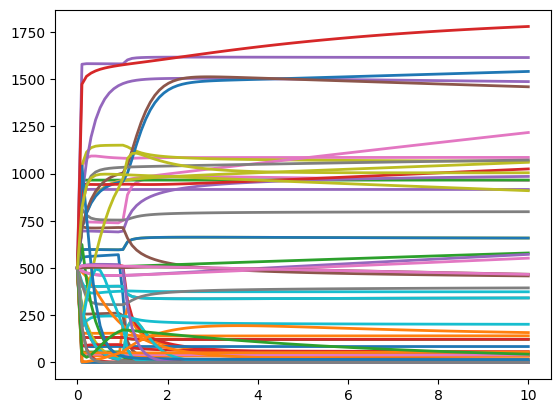

[[<matplotlib.lines.Line2D at 0x21df3a605b0>],

In [26]:
result = rr.simulate(0, 10, 100)

rr.plot(result)

In [27]:
rr.reset()

In [28]:
print(f'{rr.model.getFloatingSpeciesIds()}')


['INSR', 'INSRpY', 'IRS', 'IRSi', 'S6KpT389', 'PI3K', 'INSRccIRSccPI3K', 'PDK1', 'PDK1b', 'MTORC2', 'MTORC2b', 'AKT', 'AKTpT308', 'AKTpS473', 'AKTpp', 'MTORC1', 'MTORC1a', 'ERKpp', 'CDK46ccCYCD', 'MTORC1i', 'S6K', 'GSK3B', 'GSK3Bi', 'SOS', 'INSRccIRSccSOS', 'SOSi', 'RAF', 'RAFa', 'RAFi', 'ERK', 'MYC', 'E2F', 'MYCpS62', 'CDK2ccCYCE', 'MYCpp', 'CYCD', 'CYCDpT286', 'CYCE', 'CYCEpT380', 'P21', 'P21pT57', 'P27', 'P27pT187', 'P27i', 'CDK46', 'CDK46ccCYCDp', 'CDK2', 'CDK2ccCYCEp', 'RB', 'RBp', 'RBpp', 'E2FccRB', 'E2FccRBp', 'E2FccRBpp', 'CDK46ccCYCDccP21', 'CDK46ccCYCDccP27', 'CDK2ccCYCEccP21', 'CDK2ccCYCEccP27', 'CDK2ccCYCEccP27p']


In [31]:
species_in_model = rr.model.getFloatingSpeciesIds()
params_in_model = rr.model.getGlobalParameterIds()

change_count_specie, change_count_param = 0,0 
for col in best_row.index:
    # print(f'{col}: {best_row[col]}')
    if col in species_in_model:
        rr.model[f'init({col})'] = best_row[col]
        change_count_specie += 1
        print(f'endogenous species {col} set to {best_row[col]}')
    elif col in params_in_model:
        rr.model[f'{col}'] = best_row[col]
        change_count_param += 1
        print(f'parameter {col} set to {best_row[col]}') 
        
        
print(f'Number of species changed: {change_count_specie}, number of parameters changed: {change_count_param}')
        

parameter kc_INSULIN_INSR_INSRpY set to 0.0040605417457358585
parameter Vm_INSRpY_INSR set to 381.73747199425395
parameter kc_S6KpT389_IRS_IRSi set to 6.228351865974184
parameter Vm_IRSi_IRS set to 7.31271114406871
parameter ka_INSRpY_IRS_PI3K_INSRccIRSccPI3K set to 0.0015811577581413125
parameter kd_INSRccIRSccPI3K_INSR_IRS_PI3K set to 961.0064113320419
parameter kc_INSRccIRSccPI3K_PDK1_PDK1b set to 9.09735304462296
parameter kc_PTEN_PDK1b_PDK1 set to 115.56813440352033
parameter kc_INSRccIRSccPI3K_MTORC2_MTORC2b set to 680.0052367883005
parameter kc_PTEN_MTORC2b_MTORC2 set to 0.003445830911308465
parameter kc_PDK1b_AKT_AKTpT308 set to 0.14739817698020982
parameter Vm_AKTpT308_AKT set to 697.374952614329
parameter kc_MTORC2b_AKT_AKTpS473 set to 0.037033407511193904
parameter Vm_AKTpS473_AKT set to 178.33824267794262
parameter kc_MTORC2b_AKTpT308_AKTpp set to 2.4108007650547187
parameter kc_PDK1b_AKTpS473_AKTpp set to 3.187549467113092e-05
parameter Vm_AKTpp_AKT set to 0.00202470577067

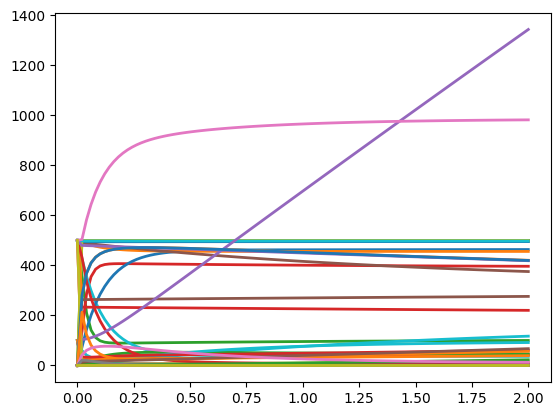

In [35]:
result = rr.simulate(0, 2, 100)

rr.plot(result)

rr.reset()

In [ ]:
rr.model["init(IRS)"]

# rr.model["init(IRS)"] = 0.5 # for changing initial conditions

In [ ]:
rr.model.getGlobalParameterIds()



In [ ]:
rr.kc_INSULIN_INSR_INSRpY

# rr.kc_INSULIN_INSR_INSRpY = 0.1 # for changing parameter values

In [ ]:
rr.model['kc_INSULIN_INSR_INSRpY'] # another method for changing parameter values

In [ ]:
rr.model['INSR'] # another method for changing initial condition values

## Linking CCLE data to Anthony's SBML model initial conditions

## Changing parameters in SBML model to the calibrated set

## Processing dynamic simulation data back to singular vector

## LanODEApp Tests

In [ ]:
'''load in core data and libraries'''

# libraries used 

# load CCLE expression data  

# load Anthony's model and optimal parameter sets 

document = reader.readSBML("data\export_ECC_Base.xml")
